<a href="https://colab.research.google.com/github/ZnCl22222/MLFP/blob/main/Topic_modeling_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 90803 MLFP-Data Cleaning and Question Definition
## Team 24: Huixuan Li (Connie), Sant Leelamanthep (Winn)
## Task 2: Topic Modeling

Notes for prof GS per call
- LDA + pyLDAvis takes a while to run
- Multiple preprocessing calls that is iterative in nature 
- In the past I've had issues with pyLDAvis on my local computer, but it works fine on colab
- Total run time of notebook around 20 minutes

# Topic modeling for scraped Reddit data
#### Resources
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
- https://www.kaggle.com/code/rcushen/topic-modelling-with-lsa-and-lda/notebook
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- https://www.kaggle.com/code/dskswu/topic-modeling-bert-lda



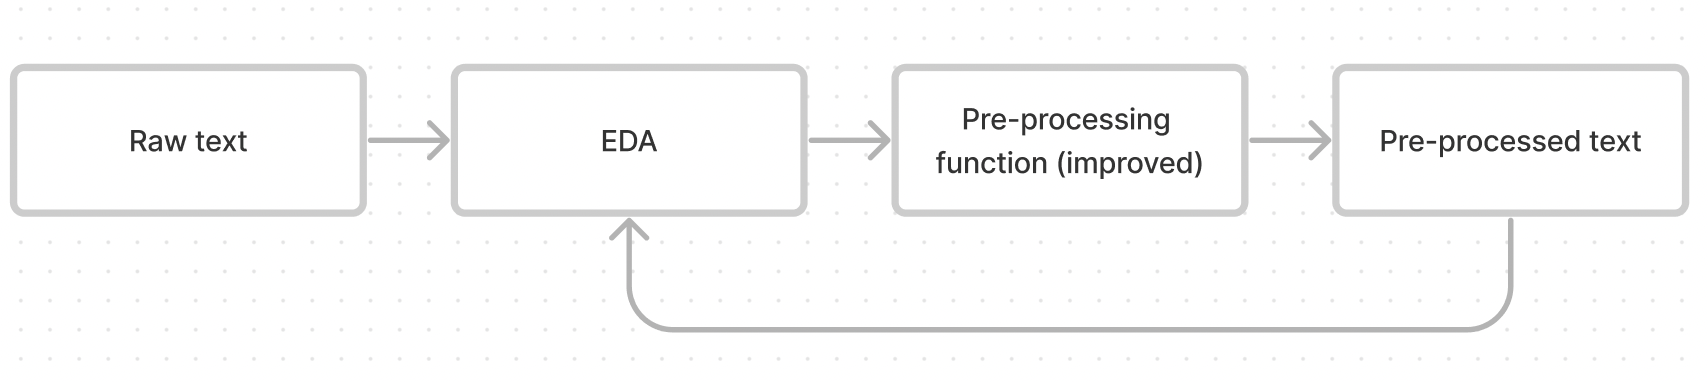

Data: scraped reddit data from 2017 to 2019 from Dexcom subreddit. In the future will aim to incorporate longer timeline + other data sources e.g. Twitter.

# Import packages and files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
#Import for pre-processing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Upload file
from google.colab import files
uploaded = files.upload()

Saving comments.csv to comments.csv


In [ ]:
# Load data
df_ = pd.read_csv('comments.csv')

df_.head(5)

,Unnamed: 0,id,submission_id,body,created_utc,parent_id,permalink
0,0,djpmuuj,6kxk7p,Screenshots are probably disabled in the app.\...,1.499058e+09,t3_6kxk7p,/r/dexcom/comments/6kxk7p/users_of_the_android...
1,1,dn9t6nq,6kxk7p,"What kind of phone? With Galaxy S8, there is a...",1.505932e+09,t3_6kxk7p,/r/dexcom/comments/6kxk7p/users_of_the_android...
2,2,dli1bso,6kxk7p,I might call tech support and ask if there is ...,1.502498e+09,t1_djpmuuj,/r/dexcom/comments/6kxk7p/users_of_the_android...
3,3,dn9tjyi,6kxk7p,S7 Edge,1.505933e+09,t1_dn9t6nq,/r/dexcom/comments/6kxk7p/users_of_the_android...
4,4,dk8f6hi,6nc5lt,"I've gone both routes, and eventual got pre ch...",1.500073e+09,t3_6nc5lt,/r/dexcom/comments/6nc5lt/traveling_with_dexco...


In [ ]:
# Rename column, Create copy of original
df = df_.loc[:,['body']]
df = df.rename(columns={'body':'text'})
df['text_original'] = df['text'].copy()

df

,text,text_original
0,Screenshots are probably disabled in the app.\...,Screenshots are probably disabled in the app.\...
1,"What kind of phone? With Galaxy S8, there is a...","What kind of phone? With Galaxy S8, there is a..."
2,I might call tech support and ask if there is ...,I might call tech support and ask if there is ...
3,S7 Edge,S7 Edge
4,"I've gone both routes, and eventual got pre ch...","I've gone both routes, and eventual got pre ch..."
...,...,...
15666,[deleted],[deleted]
15667,"You are correct and for legal purposes also, t...","You are correct and for legal purposes also, t..."
15668,Settings/xDrip+ Display Settings/Number Icon i...,Settings/xDrip+ Display Settings/Number Icon i...
15669,[deleted],[deleted]


In [ ]:
# Shape
df.shape

(15671, 2)

# EDA + viz

In [ ]:
# Give appropriate name to null-equivalent posts (nan)
dele = ['[deleted]','[removed]']
df['text'] = df['text'].replace(dele, np.nan)

# Observe na
df['text'].isna().sum()

322

Will drop all na as doing NLP, little value in deleted texts

### Initial basic cleaning and EDA

In [ ]:
# Drop na
df.dropna(inplace=True)

df

,text,text_original
0,Screenshots are probably disabled in the app.\...,Screenshots are probably disabled in the app.\...
1,"What kind of phone? With Galaxy S8, there is a...","What kind of phone? With Galaxy S8, there is a..."
2,I might call tech support and ask if there is ...,I might call tech support and ask if there is ...
3,S7 Edge,S7 Edge
4,"I've gone both routes, and eventual got pre ch...","I've gone both routes, and eventual got pre ch..."
...,...,...
15664,I was diagnosed Type 1 a little over a year ag...,I was diagnosed Type 1 a little over a year ag...
15665,Oh no that’s the hardest part 😳 Im a foodie. H...,Oh no that’s the hardest part 😳 Im a foodie. H...
15667,"You are correct and for legal purposes also, t...","You are correct and for legal purposes also, t..."
15668,Settings/xDrip+ Display Settings/Number Icon i...,Settings/xDrip+ Display Settings/Number Icon i...


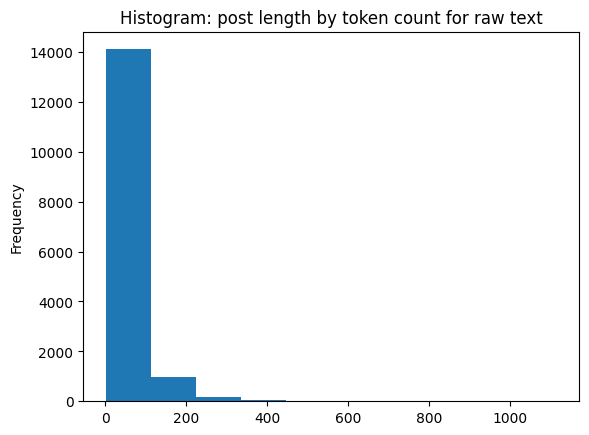

Text(0.5, 1.0, 'Boxplot: post length by token count for raw text')

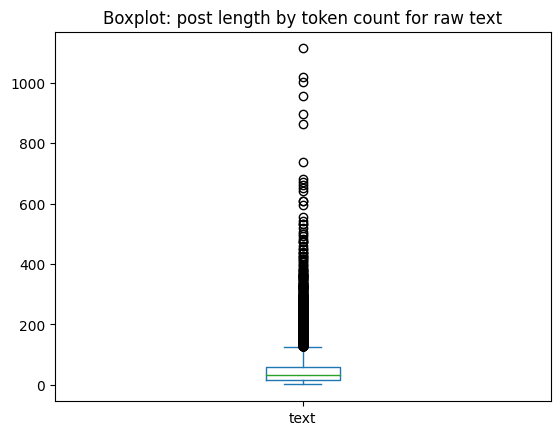

In [ ]:
# Viz lengths of posts
tokens_count = df['text'].apply(lambda x: len(word_tokenize(x)))

tokens_count.plot(kind='hist')
plt.title('Histogram: post length by token count for raw text')
plt.show()

tokens_count.plot(kind='box')
plt.title('Boxplot: post length by token count for raw text')

In [ ]:
# See common posts, subseet for at least 3 
common = pd.DataFrame(df['text'].value_counts().reset_index())

common = common[common['text'] >= 3]

common

,index,text
0,Thanks!,21
1,Thank you!,20
2,Thanks.,16
3,Thanks. Your LOT# has been added to the databa...,13
4,Yes,11
5,Thank you,10
6,Thanks,7
7,Thank you.,7
8,Welcome to our community!,7
9,Thanks. Your LOT# has been added to the databa...,6


A lot of these posts do not add value, will require removal.

In [ ]:
useful_among_common = common.iloc[[21, 23, 27, 29]]

useful_among_common

,index,text
21,The worst thing to me is a shipping waste. I a...,3
23,I use the corner of a gift card in that spot. ...,3
27,The Omnipod freestyle usually tests lower than...,3
29,Check before and after shower.,3


In [ ]:
# Create set of posts to remove
posts_to_remove = set(common['index'].values) - set(useful_among_common['index'].values)

posts_to_remove

{'Added. Thanks.',
 'G6',
 'Go sign this petition! Dexom is starting to pay attention. https://www.change.org/p/dexcom-change-your-adhesive-on-your-devices',
 'Messaged you',
 'Need a transmitter. If you do a subscription they send out what you need. Call them and talk with them.',
 'No',
 'No problem!',
 'Nope',
 "Please remember that buying, selling, or trading prescription medical devices is not allowed. Gifting supplies is allowed and you may ask the receiver to cover shipping costs. Thanks.\r\\n\r\\n***\r\\n\r\\n*This comment is added to all posts that appear likely to involve a transaction so please don't take it personally.*",
 "Removed due to Rule #7:\\n\\nTransactions for goods and services, whether gifted or sold, are prohibited by Reddit's Account and Community Restrictions. Such post/comments will be removed on report or being noticed by a moderator because it puts the sub's existence at risk. Repeated violations can result in being banned.\\n\\nr/DexcomSupplies can be used

In [ ]:
# Drop posts to remove 
def drop_posts(df, posts_to_remove):
  
    # Create a boolean mask using a lambda function
    mask = df['text'].apply(lambda x: x not in posts_to_remove)

    # Apply the mask to the DataFrame
    df_filtered = df[mask]

    # Drop rows with missing data in the 'body' column if specified
    df_filtered.dropna(inplace=True)

    return df_filtered

df = drop_posts(df, posts_to_remove)

In [ ]:
# Create function to get ngrams 
from nltk.util import ngrams   

def get_ngrams(words_list, n):
    return list(ngrams(words_list,  n))

# Create function to plot ngrams
def plot_ngram_freq(ngrams, n, top_n=20):   

    # Get frequency
    freq_dist = nltk.FreqDist(ngrams)  
    most_common = freq_dist.most_common(top_n) 
    labels, values = zip(*most_common)
    labels = [' '.join(label) for label in labels]   

    # Plot
    plt.figure(figsize=(12, 6)) 
    plt.bar(labels, values)  
    plt.xlabel(f'Top {top_n} {n}-grams') 
    plt.ylabel('Frequency') 
    plt.title(f'Frequency of Top {top_n} {n}-grams') 
    plt.xticks(rotation=45, ha='right')
    plt.show()     


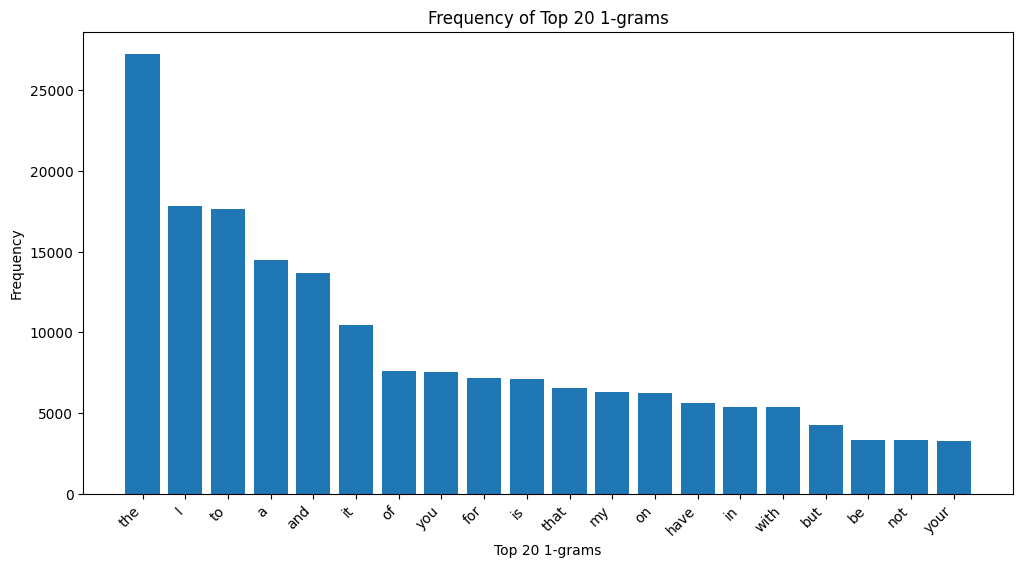

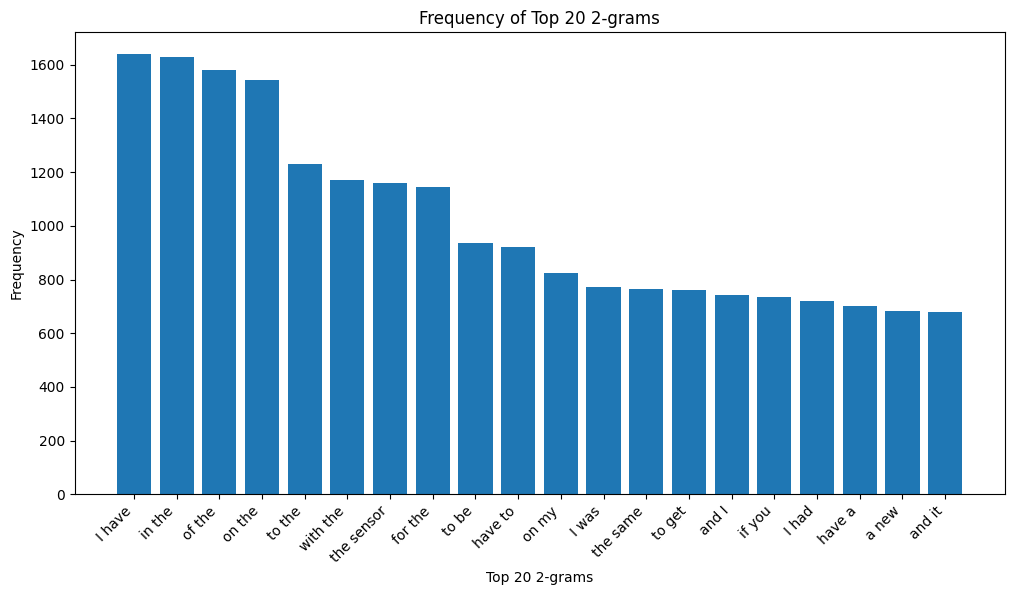

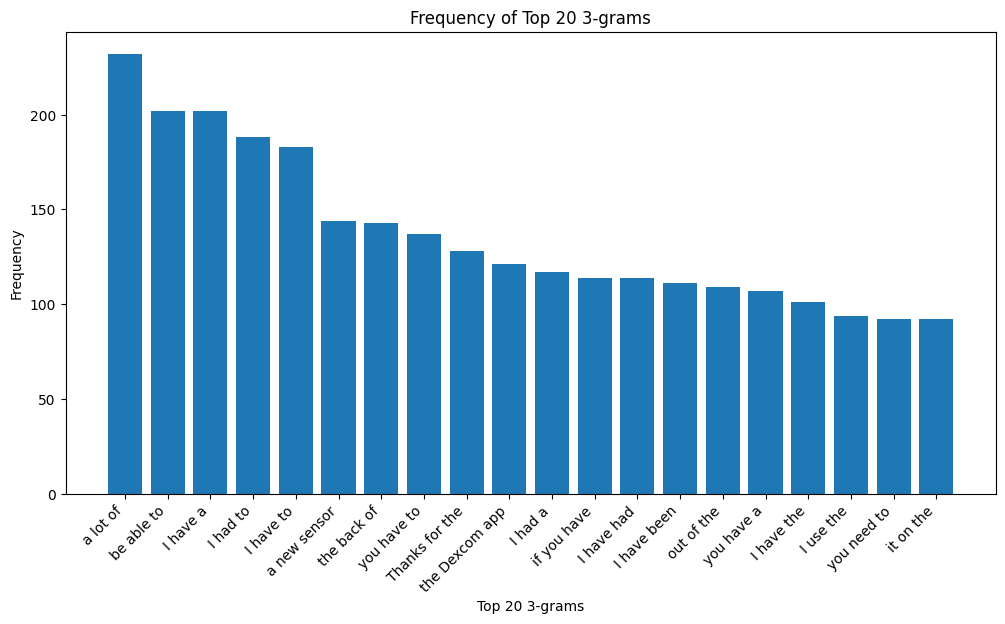

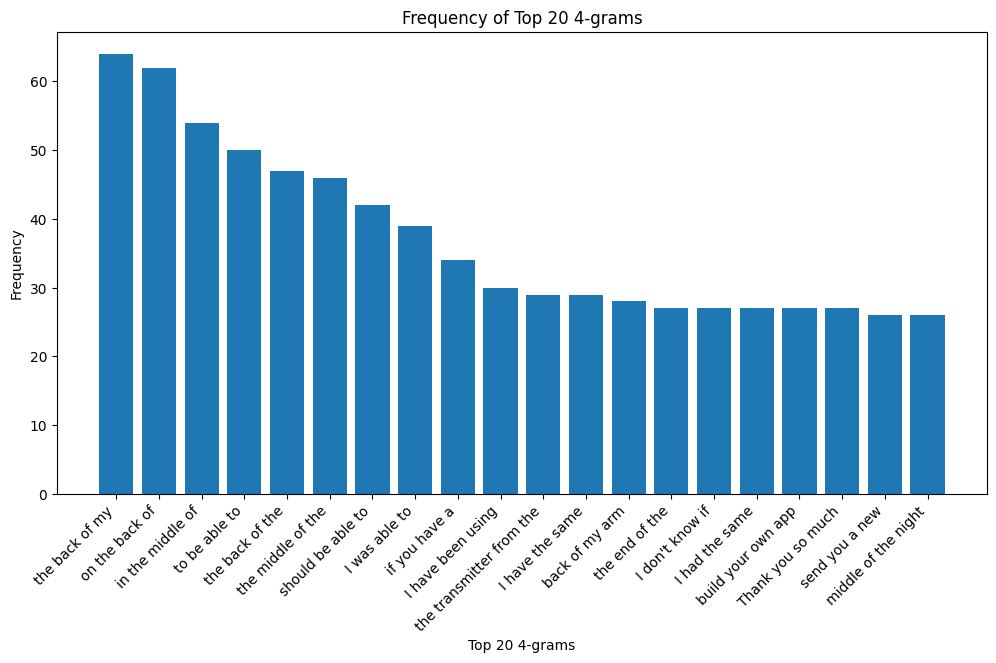

In [ ]:
# Plot ngrams to see common words 
tokens = [word for text in df['text'] for word in text.split()]

unigrams = get_ngrams(tokens, 1)
bigrams = get_ngrams(tokens, 2) 
trigrams = get_ngrams(tokens, 3)
quadrigram = get_ngrams(tokens, 4)  
    
plot_ngram_freq(unigrams, 1)
plot_ngram_freq(bigrams, 2)      
plot_ngram_freq(trigrams, 3) 
plot_ngram_freq(quadrigram, 4)

## Text cleaning

In [ ]:
# Create initial preprocessing function
def preprocess_text(text):
    # Lower case
    text = text.lower()

    # Tokenize     
    tokens = nltk.word_tokenize(text)

    # Subset for alpha-numeric, emojis may be useful for future  iterations where I will use the emot library
    tokens = [t for t in tokens if t.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [t for t in tokens if t not in stop_words]

    # Remove 2-letter words 
    tokens = [t for t in tokens if len(t) > 2]       
 

    return tokens

# Preprocess with function
df["processed"] = df["text"].apply(preprocess_text)

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized'] = df['processed'].apply(lemmatize)

In [ ]:
df["lemmatized"]

0        [screenshots, probably, disabled, disclaimer, ...
1        [kind, phone, galaxy, sidebar, app, swipe, scr...
2        [might, call, tech, support, ask, way, overrid...
3                                                   [edge]
4        [gone, route, eventual, got, pre, check, avoid...
                               ...                        
15664    [diagnosed, type, little, year, ago, use, ten,...
15665    [hardest, part, foodie, able, follow, healthy,...
15667    [correct, legal, purpose, also, need, follow, ...
15668                [display, icon, notification, switch]
15670    [sorry, well, beyond, expertise, love, organiz...
Name: lemmatized, Length: 15157, dtype: object

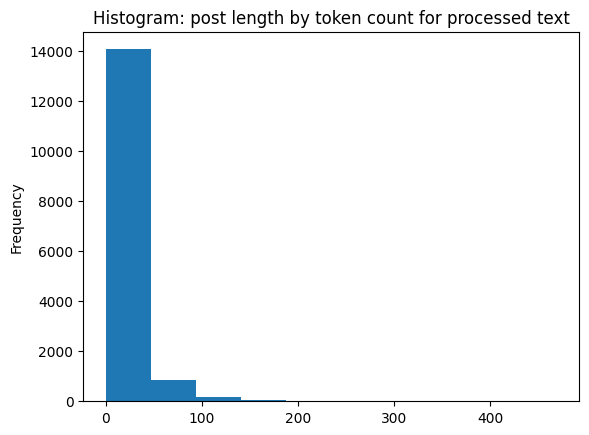

Text(0.5, 1.0, 'Boxplot: post length by token count for processed text')

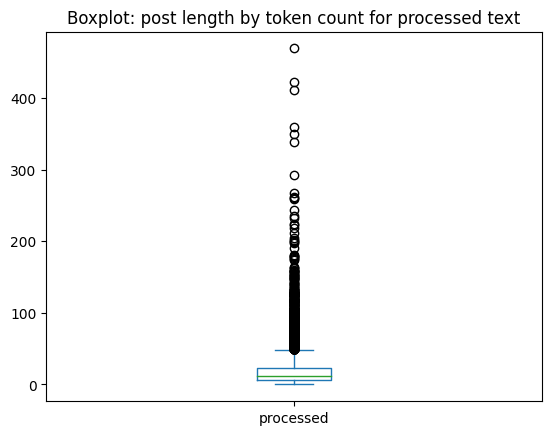

In [ ]:
# Viz lengths of posts
tokens_count = df['processed'].apply(lambda x: len(x))


tokens_count.plot(kind='hist')
plt.title('Histogram: post length by token count for processed text')
plt.show()

tokens_count.plot(kind='box')
plt.title('Boxplot: post length by token count for processed text')

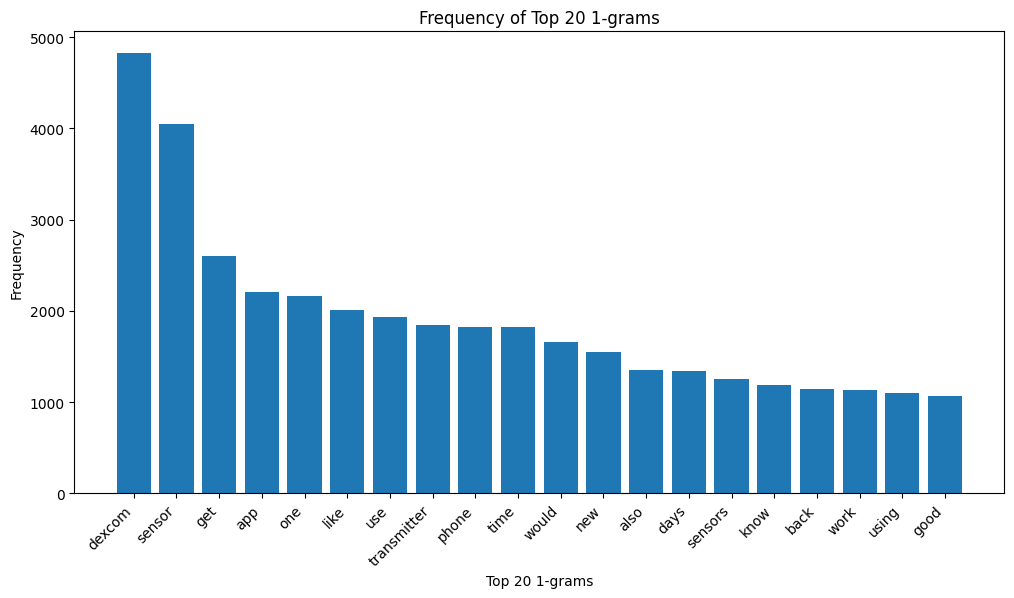

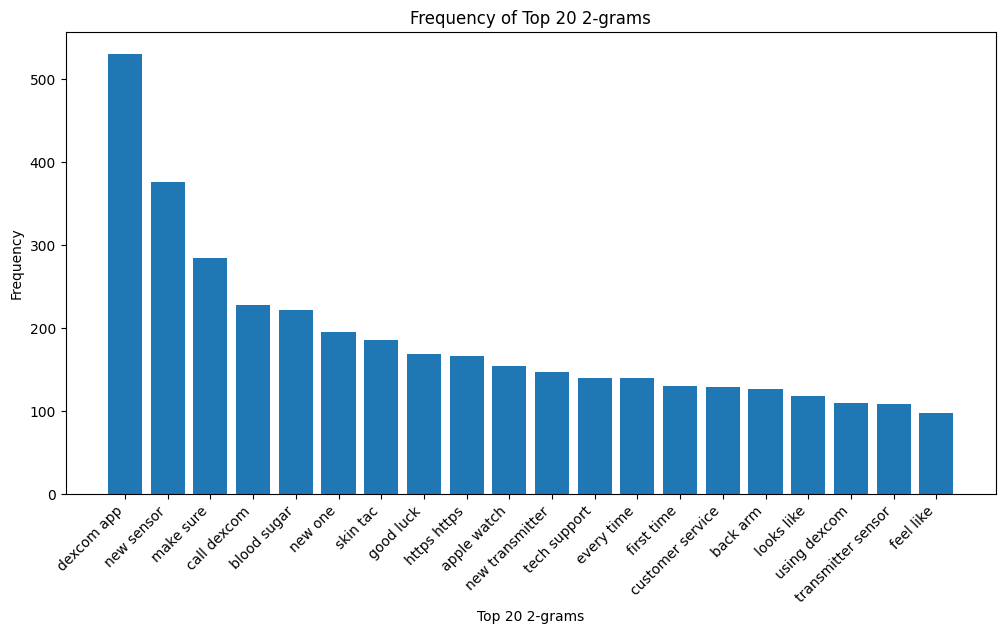

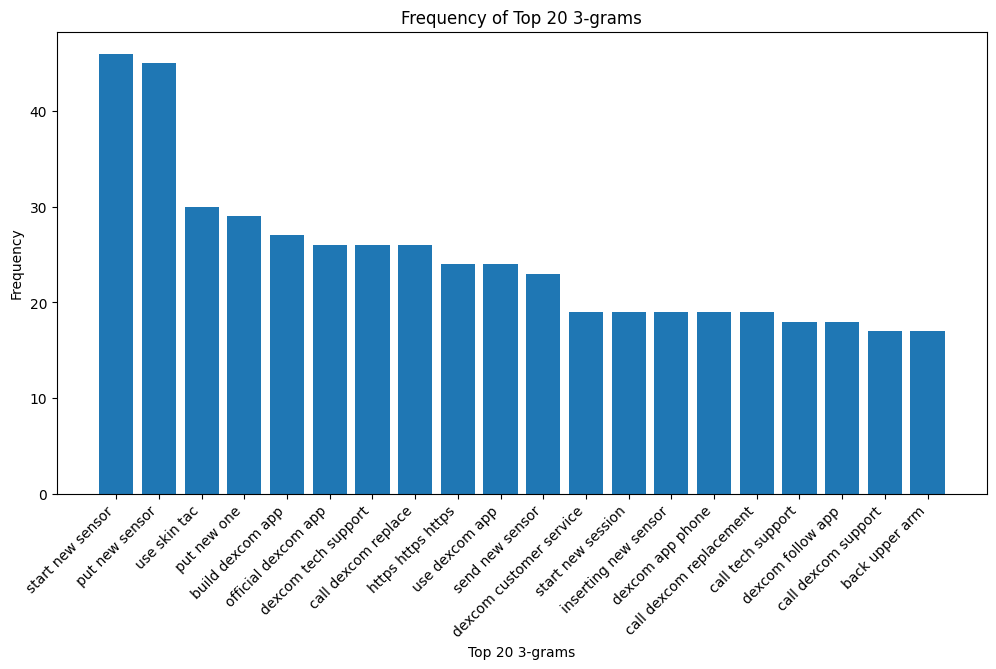

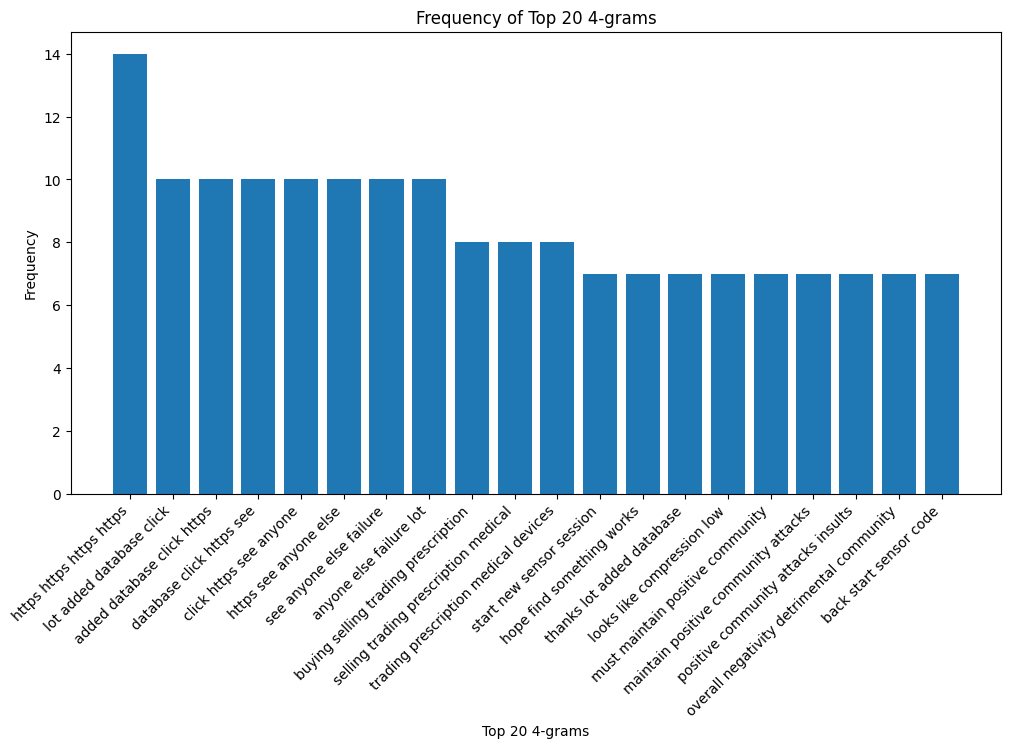

In [ ]:
# Get tokens
tokens = [token for text in df['processed'] for token in text]      

# Get ngrams    
unigrams = get_ngrams(tokens, 1)
bigrams = get_ngrams(tokens, 2) 
trigrams = get_ngrams(tokens, 3)
quadrigrams = get_ngrams(tokens, 4)  

# Plot ngrams 
plot_ngram_freq(unigrams, 1)
plot_ngram_freq(bigrams, 2)      
plot_ngram_freq(trigrams, 3) 
plot_ngram_freq(quadrigrams, 4)

In [ ]:
from nltk import FreqDist

print('unigrams', FreqDist(unigrams).most_common(10))
print('bigrams', FreqDist(bigrams).most_common(10))
print('trigrams',  FreqDist(trigrams).most_common(10))
print('quadrigrams',  FreqDist(quadrigrams).most_common(10))

unigrams [(('dexcom',), 4822), (('sensor',), 4053), (('get',), 2607), (('app',), 2202), (('one',), 2167), (('like',), 2010), (('use',), 1928), (('transmitter',), 1848), (('phone',), 1826), (('time',), 1822)]
bigrams [(('dexcom', 'app'), 530), (('new', 'sensor'), 376), (('make', 'sure'), 284), (('call', 'dexcom'), 228), (('blood', 'sugar'), 221), (('new', 'one'), 195), (('skin', 'tac'), 185), (('good', 'luck'), 168), (('https', 'https'), 166), (('apple', 'watch'), 154)]
trigrams [(('start', 'new', 'sensor'), 46), (('put', 'new', 'sensor'), 45), (('use', 'skin', 'tac'), 30), (('put', 'new', 'one'), 29), (('build', 'dexcom', 'app'), 27), (('official', 'dexcom', 'app'), 26), (('dexcom', 'tech', 'support'), 26), (('call', 'dexcom', 'replace'), 26), (('https', 'https', 'https'), 24), (('use', 'dexcom', 'app'), 24)]
quadrigrams [(('https', 'https', 'https', 'https'), 14), (('lot', 'added', 'database', 'click'), 10), (('added', 'database', 'click', 'https'), 10), (('database', 'click', 'https'

Quadrigrams show issues around http, will need removal

- a lot of http, database
- adding additional stopwords that do not add value

In [ ]:
#Remove word concatenations
#Concat dict from https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python

concat = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Create function to replace text concatenations
def replace_concatenations(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [ ]:
# Add components to text preprocessor function without removing existing components
def preprocess_text_2(text):
    # Replace text concatenations
    text = replace_concatenations(text, concat)

    # Lower
    text = text.lower()

    # Remove URLs using regex
    text = re.sub(r'http\S+', '', text)

    tokens = nltk.word_tokenize(text)

    # Tokenize
    tokens = [t for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words("english"))

    # Subset for alpha-numeric, emojis may be useful for future iterations
    tokens = [t for t in tokens if t.isalpha()]
    
    # Add custom stopwords
    custom_stopwords = [
        'get', 'one', 'like', 'use', 'would', 'also', 'know', 'back', 'need',
        'go', 'good', 'make', 'think', 'still', 'thing', 'never', 'lot'
    ]
    stop_words.update(custom_stopwords)
    
    # Remove stop words with custom stop words
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens


In [ ]:
# apply preprocessing function
df["processed_2"] = df["text"].apply(preprocess_text_2)
df['lemmatized_2'] = df['processed_2'].apply(lemmatize)

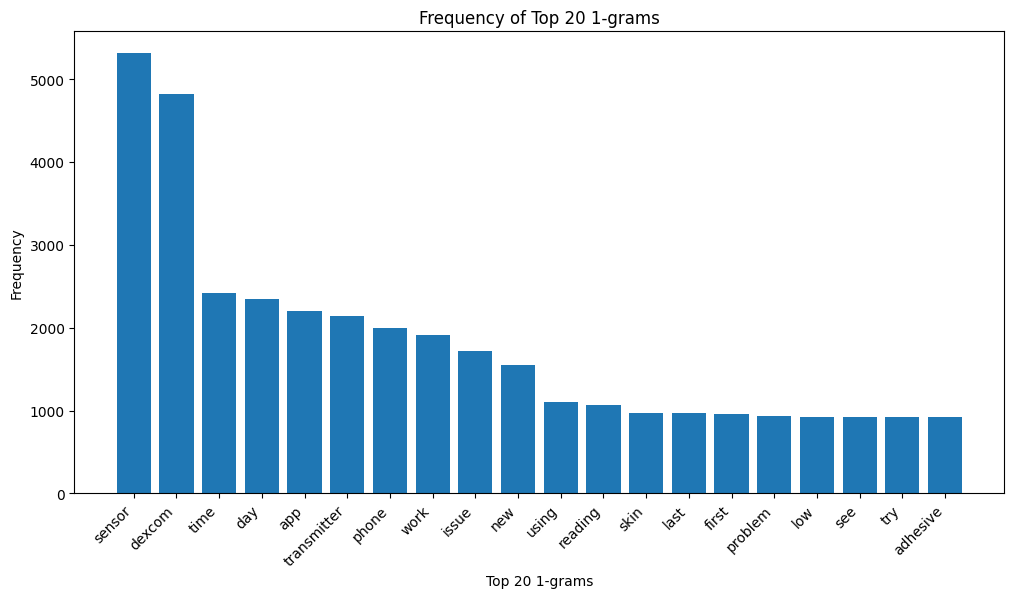

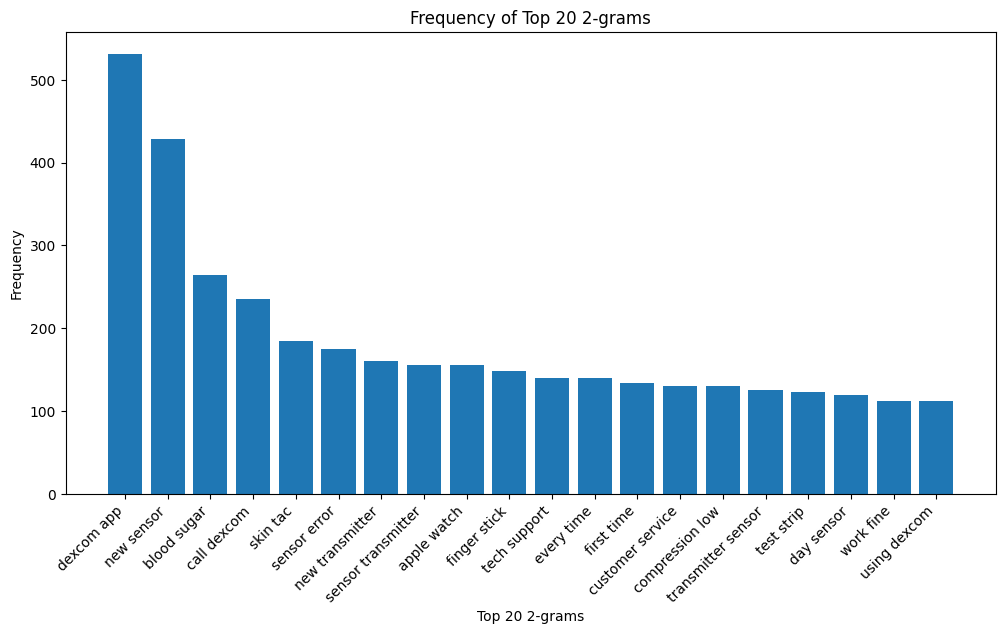

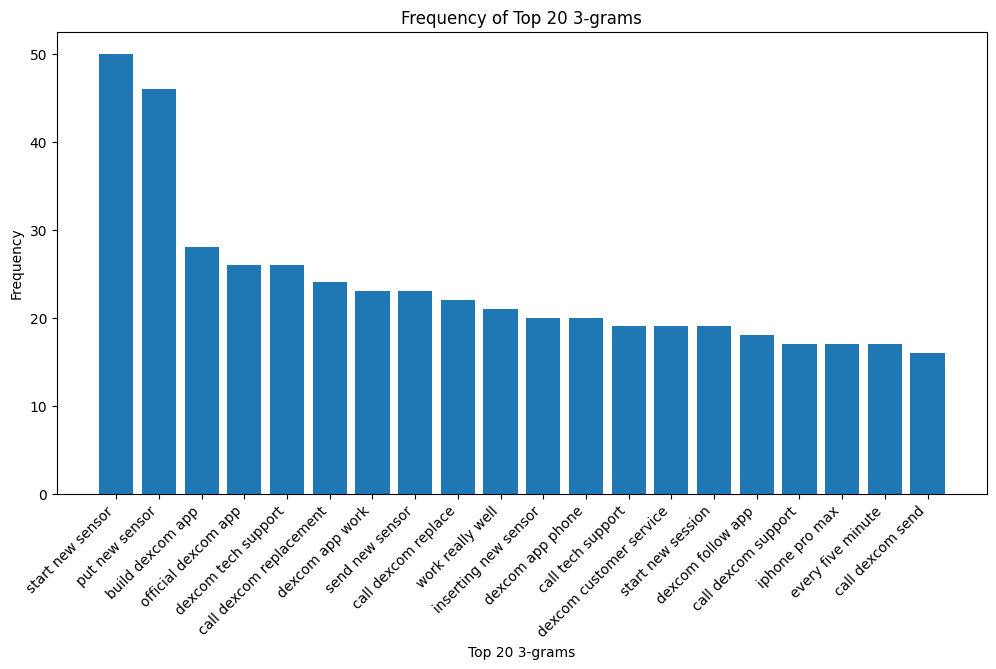

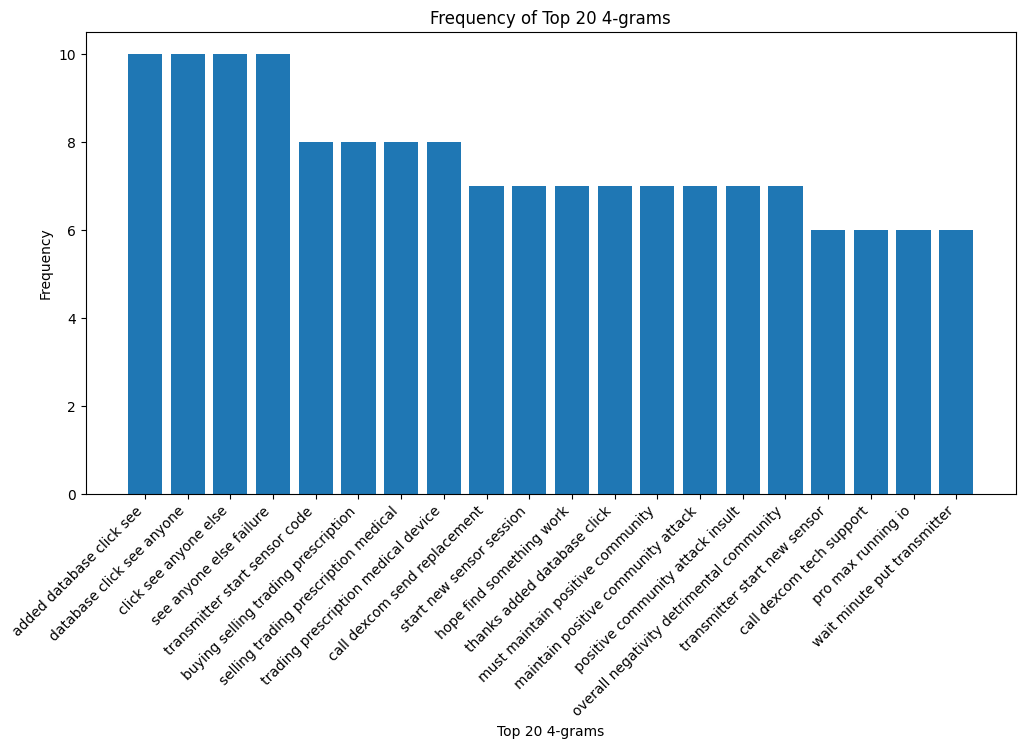

In [ ]:
# Generate unigrams, bigrams, and trigrams
tokens = [token for text in df['processed_2'] for token in text]

unigrams = get_ngrams(tokens, 1)
bigrams = get_ngrams(tokens, 2)
trigrams = get_ngrams(tokens, 3)
quadrigrams = get_ngrams(tokens, 4)
    
plot_ngram_freq(unigrams, 1)
plot_ngram_freq(bigrams, 2)
plot_ngram_freq(trigrams, 3)
plot_ngram_freq(quadrigrams, 4)

In [ ]:
print('unigrams', FreqDist(unigrams).most_common(10))
print('bigrams', FreqDist(bigrams).most_common(10))
print('trigrams',  FreqDist(trigrams).most_common(10))
print('quadrigrams',  FreqDist(quadrigrams).most_common(10))
print('')

unigrams [(('sensor',), 5311), (('dexcom',), 4822), (('time',), 2415), (('day',), 2350), (('app',), 2202), (('transmitter',), 2141), (('phone',), 1999), (('work',), 1913), (('issue',), 1719), (('new',), 1555)]
bigrams [(('dexcom', 'app'), 531), (('new', 'sensor'), 428), (('blood', 'sugar'), 264), (('call', 'dexcom'), 235), (('skin', 'tac'), 185), (('sensor', 'error'), 175), (('new', 'transmitter'), 161), (('sensor', 'transmitter'), 156), (('apple', 'watch'), 156), (('finger', 'stick'), 148)]
trigrams [(('start', 'new', 'sensor'), 50), (('put', 'new', 'sensor'), 46), (('build', 'dexcom', 'app'), 28), (('official', 'dexcom', 'app'), 26), (('dexcom', 'tech', 'support'), 26), (('call', 'dexcom', 'replacement'), 24), (('dexcom', 'app', 'work'), 23), (('send', 'new', 'sensor'), 23), (('call', 'dexcom', 'replace'), 22), (('work', 'really', 'well'), 21)]
quadrigrams [(('added', 'database', 'click', 'see'), 10), (('database', 'click', 'see', 'anyone'), 10), (('click', 'see', 'anyone', 'else'), 

Not sure about some quadrigrams, will attempt modeling and see if the issue is limiting <br>
(('added', 'database', 'click', 'see'), 10), 
(('database', 'click', 'see', 'anyone'), 10),
(('click', 'see', 'anyone', 'else'), 10)

given all count = 10, likely from the same posts. will explore with mask.

#### Add items to post to remove based on relevance

In [ ]:
phrase = 'must maintain positive community'

# Create a function to check if the phrase is present in the list of tokens
def contains_phrase(tokens, phrase):
    joined_tokens = ' '.join(tokens)
    return phrase in joined_tokens

# Filter the DataFrame
filtered_df = df[df['processed_2'].apply(lambda x: contains_phrase(x, phrase))]



In [ ]:
posts_to_remove = set((filtered_df['text'].unique()))

posts_to_remove

{'Removed as per our Posting Rules:\\n\\n>10\\. Posters must maintain a positive community. Attacks, insults, name-calling, FUD, calls for harm, and overall negativity are detrimental to the community and are not tolerated. Violators can be banned on their first offense of this rule.\\n\\nThank you,\\n/r/Dexcom Mod Team',
 'Removed for Violating Rule #1: Personal Attacks, Targeted Harassment & Uncivil Behavior.\r\\n\r\\nUsers must maintain a positive community. Attacks, insults, bigotry, name-calling, slurs, marginalization, FUD, calls for harm, and overall negativity are detrimental to the community and are not tolerated. This includes marginalizing people based on:\r\\n\r\\n* Age\r\\n* Caste\r\\n* Disability\r\\n* Ethnicity\r\\n* Gender Identity and Expression\r\\n* Nationality\r\\n* Race\r\\n* Immigration Status\r\\n* Religion\r\\n* Sex/Gender\r\\n* Sexual Orientation',
 'Removed for Violating Rule #1: Personal Attacks, Targeted Harassment & Uncivil Behavior.\r\\n\r\\nUsers must mai

In [ ]:
phrase = 'added database click'

# Filter the DataFrame
filtered_df = df[df['processed_2'].apply(lambda x: contains_phrase(x, phrase))]

posts_to_remove = posts_to_remove.union(set((filtered_df['text'].unique())))

In [ ]:
phrase = 'see anyone else failure'

# Filter the DataFrame
filtered_df = df[df['processed_2'].apply(lambda x: contains_phrase(x, phrase))]

posts_to_remove = posts_to_remove.union(set((filtered_df['text'].unique())))

In [ ]:
phrase = 'transmitter start sensor code'

# Filter the DataFrame
filtered_df = df[df['processed_2'].apply(lambda x: contains_phrase(x, phrase))]

filtered_df

# this is likely useful so will not remove

,text,text_original,processed,lemmatized,processed_2,lemmatized_2
6705,"Stop the sensor, use a test strip or a guitar ...","Stop the sensor, use a test strip or a guitar ...","[stop, sensor, use, test, strip, guitar, pick,...","[stop, sensor, use, test, strip, guitar, pick,...","[stop, sensor, test, strip, guitar, pick, pop,...","[stop, sensor, test, strip, guitar, pick, pop,..."
8382,"Stop sensor (or let it expire), remove the tra...","Stop sensor (or let it expire), remove the tra...","[stop, sensor, let, expire, remove, transmitte...","[stop, sensor, let, expire, remove, transmitte...","[stop, sensor, let, expire, remove, transmitte...","[stop, sensor, let, expire, remove, transmitte..."
8406,Call Dexcom to have them replace the one that ...,Call Dexcom to have them replace the one that ...,"[call, dexcom, replace, one, fell, restart, st...","[call, dexcom, replace, one, fell, restart, st...","[call, dexcom, replace, fell, restart, stop, s...","[call, dexcom, replace, fell, restart, stop, s..."
8588,"Stop sensor, or let it expire. Remove the tran...","Stop sensor, or let it expire. Remove the tran...","[stop, sensor, let, expire, remove, transmitte...","[stop, sensor, let, expire, remove, transmitte...","[stop, sensor, let, expire, remove, transmitte...","[stop, sensor, let, expire, remove, transmitte..."
8831,Stop the sensor or let it expire on its own. T...,Stop the sensor or let it expire on its own. T...,"[stop, sensor, let, expire, take, transmitter,...","[stop, sensor, let, expire, take, transmitter,...","[stop, sensor, let, expire, take, transmitter,...","[stop, sensor, let, expire, take, transmitter,..."
8935,"Stop sensor, or let it stop on its own. Remove...","Stop sensor, or let it stop on its own. Remove...","[stop, sensor, let, stop, remove, transmitter,...","[stop, sensor, let, stop, remove, transmitter,...","[stop, sensor, let, stop, remove, transmitter,...","[stop, sensor, let, stop, remove, transmitter,..."
10637,You can restart the sensor if you have to. Hit...,You can restart the sensor if you have to. Hit...,"[restart, sensor, hit, stop, sensor, remove, t...","[restart, sensor, hit, stop, sensor, remove, t...","[restart, sensor, hit, stop, sensor, remove, t...","[restart, sensor, hit, stop, sensor, remove, t..."
10734,"Yes, I would pick one of the devices to start ...","Yes, I would pick one of the devices to start ...","[yes, would, pick, one, devices, start, pair, ...","[yes, would, pick, one, device, start, pair, n...","[yes, pick, device, start, pair, new, transmit...","[yes, pick, device, start, pair, new, transmit..."


In [ ]:
phrase = 'call dexcom tech support'

# Filter the DataFrame
filtered_df = df[df['processed_2'].apply(lambda x: contains_phrase(x, phrase))]

posts_to_remove = posts_to_remove.union(set((filtered_df['text'].unique())))

In [ ]:
# drop additional posts that have minimal information 
df = drop_posts(df, posts_to_remove)

df

,text,text_original,processed,lemmatized,processed_2,lemmatized_2
0,Screenshots are probably disabled in the app.\...,Screenshots are probably disabled in the app.\...,"[screenshots, probably, disabled, disclaimer, ...","[screenshots, probably, disabled, disclaimer, ...","[screenshots, probably, disabled, disclaimer, ...","[screenshots, probably, disabled, disclaimer, ..."
1,"What kind of phone? With Galaxy S8, there is a...","What kind of phone? With Galaxy S8, there is a...","[kind, phone, galaxy, sidebar, app, swipe, scr...","[kind, phone, galaxy, sidebar, app, swipe, scr...","[kind, phone, galaxy, sidebar, app, swipe, scr...","[kind, phone, galaxy, sidebar, app, swipe, scr..."
2,I might call tech support and ask if there is ...,I might call tech support and ask if there is ...,"[might, call, tech, support, ask, way, overrid...","[might, call, tech, support, ask, way, overrid...","[might, call, tech, support, ask, way, overrid...","[might, call, tech, support, ask, way, overrid..."
3,S7 Edge,S7 Edge,[edge],[edge],[edge],[edge]
4,"I've gone both routes, and eventual got pre ch...","I've gone both routes, and eventual got pre ch...","[gone, routes, eventual, got, pre, check, avoi...","[gone, route, eventual, got, pre, check, avoid...","[gone, route, eventual, got, pre, check, avoid...","[gone, route, eventual, got, pre, check, avoid..."
...,...,...,...,...,...,...
15664,I was diagnosed Type 1 a little over a year ag...,I was diagnosed Type 1 a little over a year ag...,"[diagnosed, type, little, year, ago, use, tens...","[diagnosed, type, little, year, ago, use, ten,...","[diagnosed, type, little, year, ago, ten, unit...","[diagnosed, type, little, year, ago, ten, unit..."
15665,Oh no that’s the hardest part 😳 Im a foodie. H...,Oh no that’s the hardest part 😳 Im a foodie. H...,"[hardest, part, foodie, able, follow, healthy,...","[hardest, part, foodie, able, follow, healthy,...","[oh, hardest, part, im, foodie, able, follow, ...","[oh, hardest, part, im, foodie, able, follow, ..."
15667,"You are correct and for legal purposes also, t...","You are correct and for legal purposes also, t...","[correct, legal, purposes, also, need, follow,...","[correct, legal, purpose, also, need, follow, ...","[correct, legal, purpose, follow, script, clea...","[correct, legal, purpose, follow, script, clea..."
15668,Settings/xDrip+ Display Settings/Number Icon i...,Settings/xDrip+ Display Settings/Number Icon i...,"[display, icon, notification, switches]","[display, icon, notification, switch]","[display, icon, notification, switch]","[display, icon, notification, switch]"


### Final cleaning

In [ ]:
# repeat processing function with same preprocessing function after dropping
df["processed_3"] = df["text"].apply(preprocess_text_2)
df['lemmatized_3'] = df['processed_3'].apply(lemmatize)

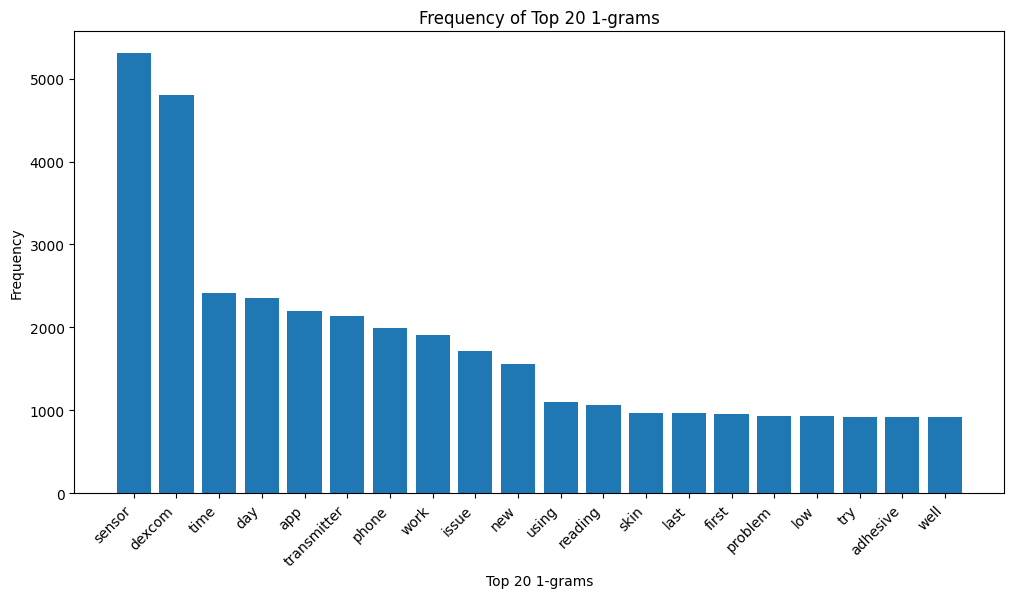

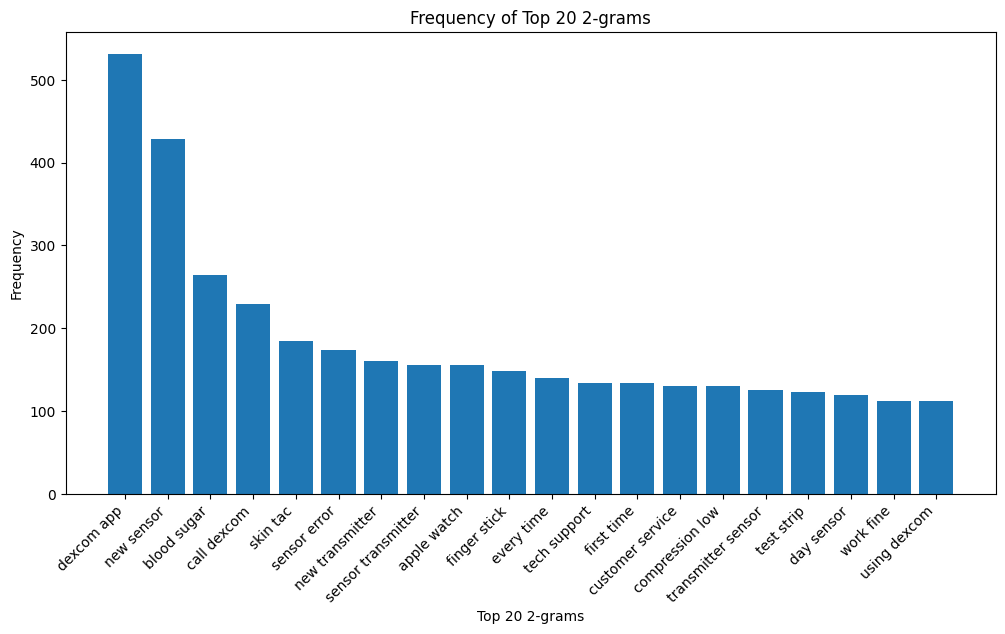

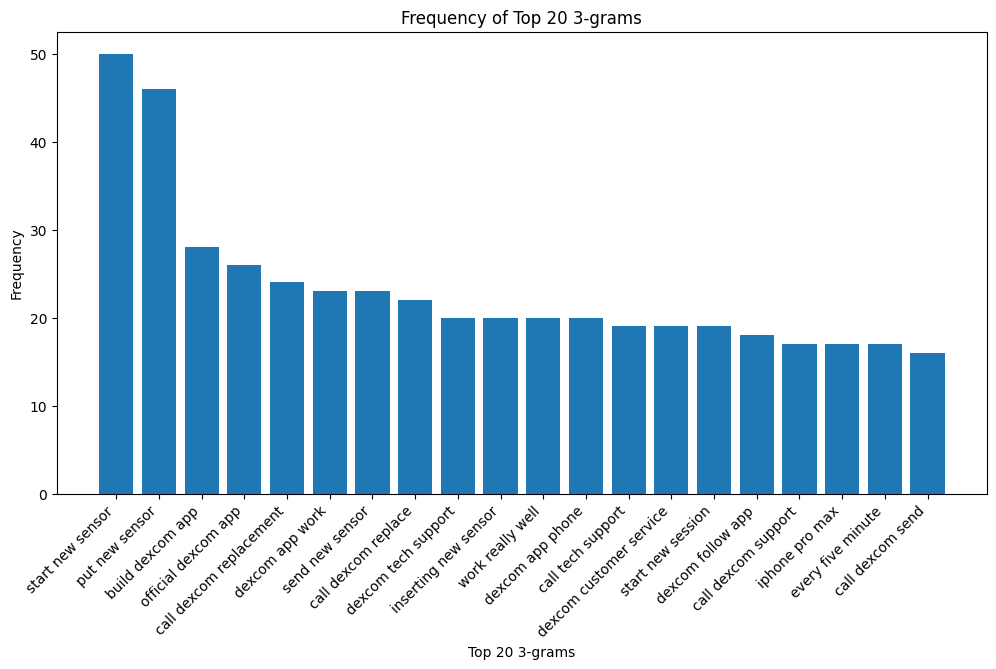

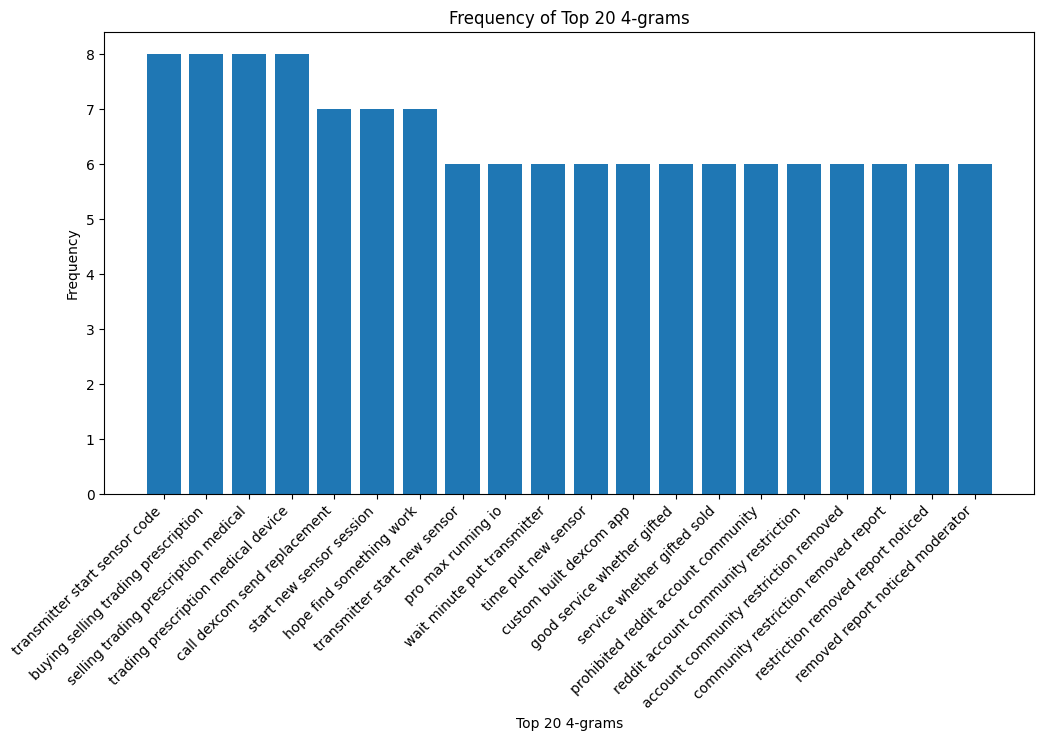

In [ ]:
# Generate unigrams, bigrams, and trigrams
tokens = [token for text in df['processed_2'] for token in text]

unigrams = get_ngrams(tokens, 1)
bigrams = get_ngrams(tokens, 2)
trigrams = get_ngrams(tokens, 3)
quadrigrams = get_ngrams(tokens, 4)
    
plot_ngram_freq(unigrams, 1)
plot_ngram_freq(bigrams, 2)
plot_ngram_freq(trigrams, 3)
plot_ngram_freq(quadrigrams, 4)

### Baseline model + viz with pyLDA viz

In [ ]:
pip install pyLDAvis gensim


#### Create dictionary, doc term matrix, tfidf vectorized matrix

In [ ]:
# Convert list of tokens to string
df['final'] = df['processed_3'].apply(lambda x: ' '.join(x))


In [ ]:
from gensim.models import TfidfModel

# Create dictionary based on dict
dictionary = corpora.Dictionary([doc.split() for doc in df['final']])

# Create document term matrix 
doc_term_matrix = [dictionary.doc2bow(doc.split()) for doc in df['final']]

# Create TF-IDF model
tfidf = TfidfModel(doc_term_matrix)
tfidf_matrix = tfidf[doc_term_matrix]


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import LdaModel

# Create an LDA model using gensim
num_topics = 5
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=15)

#### Viz with pyLDAvis

In [ ]:
# Prepare and display the LDA visualization using pyLDAvis
lda_vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(lda_vis)



Topics 2 and 3 may be too closely linked, potentially mergeable into 1 topic.

In [ ]:
topics = lda_model.print_topics(num_words=10)

for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")

df["topic"] = [sorted(lda_model[doc], key=lambda x: x[1], reverse=True)[0][0] for doc in doc_term_matrix]


Topic 1: 0.069*"sensor" + 0.038*"transmitter" + 0.021*"day" + 0.021*"new" + 0.019*"time" + 0.015*"dexcom" + 0.012*"hour" + 0.010*"last" + 0.009*"issue" + 0.009*"error"
Topic 2: 0.039*"app" + 0.032*"dexcom" + 0.030*"phone" + 0.016*"work" + 0.015*"watch" + 0.010*"device" + 0.009*"data" + 0.009*"issue" + 0.009*"receiver" + 0.008*"thanks"
Topic 3: 0.013*"dexcom" + 0.012*"time" + 0.012*"low" + 0.010*"reading" + 0.009*"blood" + 0.008*"day" + 0.007*"really" + 0.007*"much" + 0.006*"year" + 0.006*"people"
Topic 4: 0.029*"sensor" + 0.019*"adhesive" + 0.019*"skin" + 0.018*"arm" + 0.011*"patch" + 0.010*"day" + 0.010*"put" + 0.010*"dexcom" + 0.009*"work" + 0.007*"using"
Topic 5: 0.022*"dexcom" + 0.016*"insurance" + 0.011*"call" + 0.009*"supply" + 0.009*"month" + 0.008*"company" + 0.008*"order" + 0.007*"customer" + 0.007*"pay" + 0.007*"u"


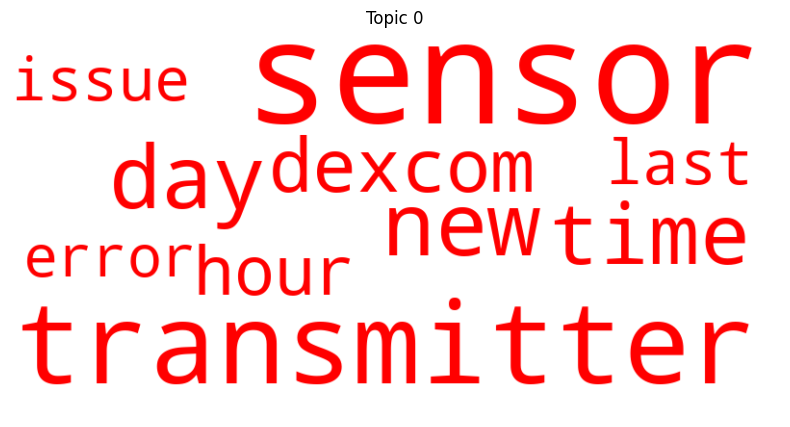

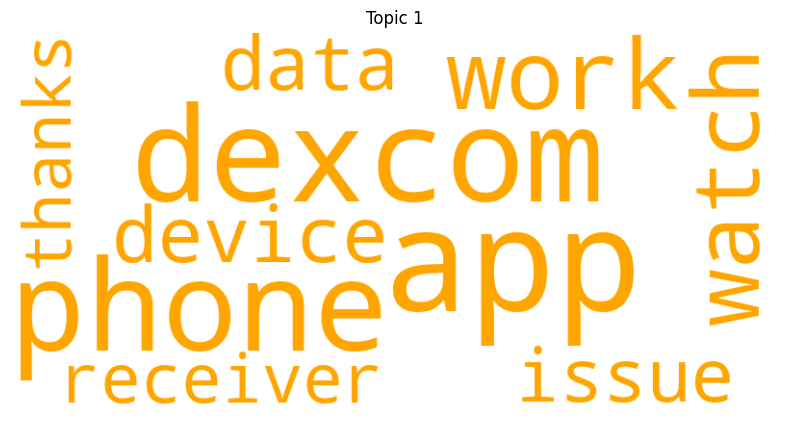

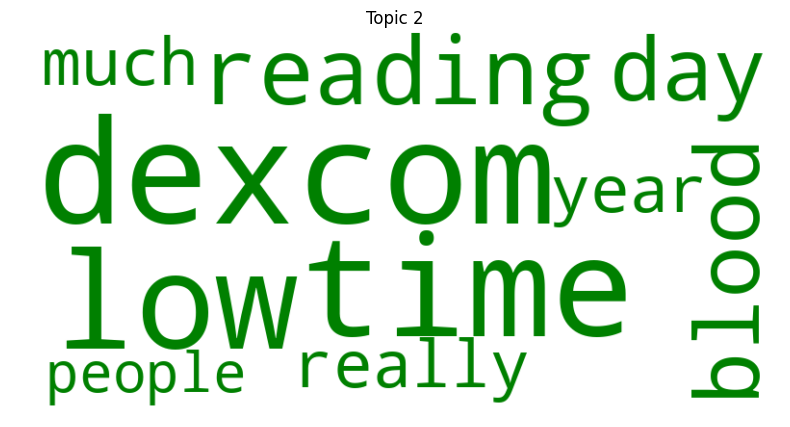

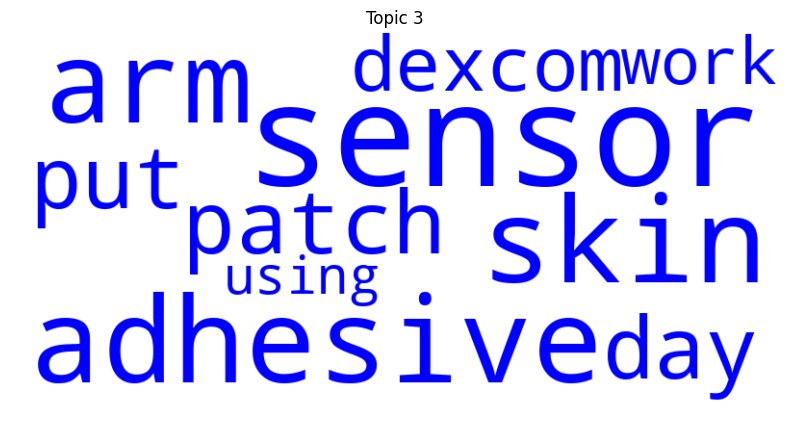

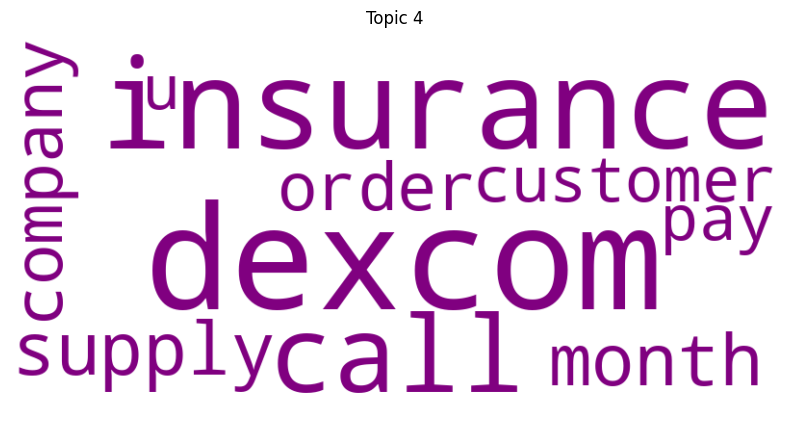

In [ ]:
from wordcloud import WordCloud

colors = ["red", "orange", "green", "blue", "purple"]

# Iterate over topics
for i in range(num_topics):
    # Get top 10 words for current topic
    topic_words = lda_model.show_topic(i, 10)
    topic_words_dict = {word:score for word, score in topic_words}
    
    # Create word cloud for current topic
    wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: colors[i % len(colors)], max_font_size=150, width=800, height=400)
    wc.generate_from_frequencies(topic_words_dict)

    # Plot word cloud for current topic
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()

General inference<br>
Topic 1: app and phone compatibility with transmitters [dexcom, app, phone, receiver, transmitter] <br>
Topic 2: sensor reading, issues with performance around accuracy, issues with sensor lasting for full day [sensor, day, time, reading]<br>
Topic 3: customer service and insurance [descom, call, support, insurance]<br>
Topic 4: general feedback and interactions on platform [thanks, thank, really, post, lol]<br>
Topic 5: adhesive issues with device [adhesive, skin, patch, sensor]

#### Data now cleaned, baseline model complete

# Topic Modeling with LDA

In [ ]:
from gensim.models import CoherenceModel

# Create LDA model
def create_lda_model(dtm=doc_term_matrix, dictionary=dictionary, num_topics=5, passes=15):
    lda_model = LdaModel(dtm, num_topics=num_topics, id2word=dictionary, passes=passes, random_state = 42)
    return lda_model

# Print topics
def print_topics(lda_model, num_words=10):
    topics = lda_model.print_topics(num_words=num_words)
    for idx, topic in topics:
        print(f"Topic {idx + 1}: {topic}")

# Output topic onto df
def assign_topics_to_df(df=df, lda_model=lda_model, corpus=doc_term_matrix):
    df["topic"] = [sorted(lda_model[doc], key=lambda x: x[1], reverse=True)[0][0] for doc in corpus]

# Calculate coherence score
def calculate_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()


NameError: ignored

In [ ]:
# Use function from above to model, assign
num_topics = 5
lda_model = create_lda_model(num_topics=num_topics)
print_topics(lda_model)
assign_topics_to_df()

topics = lda_model.show_topics()

topics

Topic 1: 0.017*"thanks" + 0.011*"thank" + 0.011*"much" + 0.010*"really" + 0.009*"issue" + 0.008*"people" + 0.008*"post" + 0.008*"help" + 0.007*"dexcom" + 0.007*"work"
Topic 2: 0.039*"app" + 0.037*"phone" + 0.029*"transmitter" + 0.028*"dexcom" + 0.016*"work" + 0.015*"watch" + 0.014*"sensor" + 0.012*"new" + 0.011*"receiver" + 0.009*"using"
Topic 3: 0.031*"dexcom" + 0.018*"sensor" + 0.014*"call" + 0.009*"time" + 0.009*"insurance" + 0.009*"replacement" + 0.009*"month" + 0.008*"day" + 0.008*"issue" + 0.008*"support"
Topic 4: 0.040*"sensor" + 0.019*"adhesive" + 0.019*"skin" + 0.018*"arm" + 0.012*"day" + 0.011*"put" + 0.010*"patch" + 0.009*"dexcom" + 0.008*"work" + 0.008*"using"
Topic 5: 0.020*"sensor" + 0.018*"time" + 0.017*"day" + 0.016*"reading" + 0.012*"hour" + 0.011*"dexcom" + 0.011*"blood" + 0.010*"low" + 0.009*"calibrate" + 0.007*"sugar"


[(0,
  '0.017*"thanks" + 0.011*"thank" + 0.011*"much" + 0.010*"really" + 0.009*"issue" + 0.008*"people" + 0.008*"post" + 0.008*"help" + 0.007*"dexcom" + 0.007*"work"'),
 (1,
  '0.039*"app" + 0.037*"phone" + 0.029*"transmitter" + 0.028*"dexcom" + 0.016*"work" + 0.015*"watch" + 0.014*"sensor" + 0.012*"new" + 0.011*"receiver" + 0.009*"using"'),
 (2,
  '0.031*"dexcom" + 0.018*"sensor" + 0.014*"call" + 0.009*"time" + 0.009*"insurance" + 0.009*"replacement" + 0.009*"month" + 0.008*"day" + 0.008*"issue" + 0.008*"support"'),
 (3,
  '0.040*"sensor" + 0.019*"adhesive" + 0.019*"skin" + 0.018*"arm" + 0.012*"day" + 0.011*"put" + 0.010*"patch" + 0.009*"dexcom" + 0.008*"work" + 0.008*"using"'),
 (4,
  '0.020*"sensor" + 0.018*"time" + 0.017*"day" + 0.016*"reading" + 0.012*"hour" + 0.011*"dexcom" + 0.011*"blood" + 0.010*"low" + 0.009*"calibrate" + 0.007*"sugar"')]

2
Number of Topics: 2, Coherence Score: 0.5739
3
Number of Topics: 3, Coherence Score: 0.6339
4
Number of Topics: 4, Coherence Score: 0.6437
5
Number of Topics: 5, Coherence Score: 0.6371
6
Number of Topics: 6, Coherence Score: 0.6270
7
Number of Topics: 7, Coherence Score: 0.6190
8
Number of Topics: 8, Coherence Score: 0.6546
9
Number of Topics: 9, Coherence Score: 0.6331
10
Number of Topics: 10, Coherence Score: 0.6467


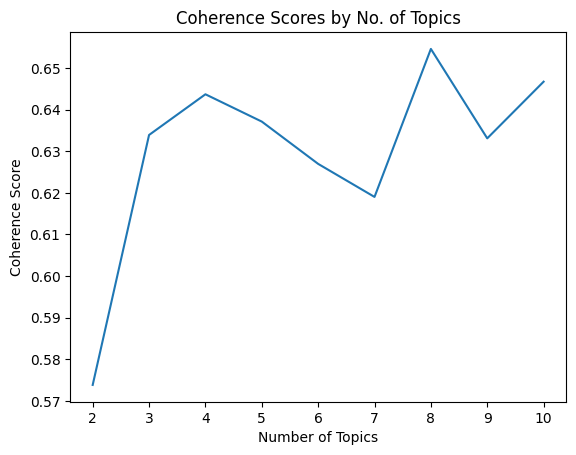

In [ ]:
texts = [doc.split() for doc in df['final']]

# Set min and max n topics
min_topics = 2
max_topics = 10

# Initialize lists to store results  
num_topics_list = []
coherence_scores = []

# Loop through the number of topics, model, assign, plot
for num_topics in range(min_topics, max_topics + 1):
    print(num_topics) 

    lda_model = create_lda_model(doc_term_matrix, dictionary, num_topics)
    coherence_score = calculate_coherence(lda_model, texts, dictionary)
    
    num_topics_list.append(num_topics)
    coherence_scores.append(coherence_score)    
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Plot the coherence scores
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by No. of Topics")
plt.xticks(num_topics_list)
plt.show()

### Elbow coherence = 0.64, n = 4
Loop took about 14 minutes to run on colab

In [ ]:
lda_model = create_lda_model(doc_term_matrix, dictionary, 4)
topics = lda_model.show_topics()

topics

NameError: ignored

In [ ]:
from wordcloud import WordCloud

colors = ["red", "orange", "green", "blue"]

# Iterate over topics
for i in range(4):
    # Get top 10 words for current topic
    topic_words = lda_model.show_topic(i, 10)
    topic_words_dict = {word:score for word, score in topic_words}
    
    # Create word cloud for current topic
    wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: colors[i % len(colors)], max_font_size=150, width=800, height=400)
    wc.generate_from_frequencies(topic_words_dict)

    # Plot word cloud for current topic
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()

NameError: ignored

Topic 1: frequency and time of reading [time, reading, hour, low, sensor]<br>

Topic 2: use of mobile devices and tech ecosystem [app, phone, watch, transmitter]<br>

Topic 3: issues and support around getting devices [call, issue, insurance, replacement]

Topic 4: issues around skin attachment [sensor, adhesive, skin, arm, day, put, patch]

In [ ]:
# Step 1: Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# Step 2: Convert preprocessed text data to list of strings
texts = [' '.join(doc.split()) for doc in df['final']]

# Step 3: Create a TF-IDF vectorizer and fit it to the text data
tfidf_vectorizer = TfidfVectorizer()
doc_word_matrix = tfidf_vectorizer.fit_transform(texts)

# Step 4: Set minimum and maximum number of topics
min_topics = 2
max_topics = 10

# Step 5: Initialize lists to store results
num_topics_list = []
coherence_scores = []

# Step 6: Loop through number of topics and fit NMF model
for num_topics in range(min_topics, max_topics + 1):
    print(num_topics)
    model = NMF(n_components=num_topics, init='nndsvd', random_state=0)
    doc_topic_matrix = model.fit_transform(doc_word_matrix)

    # Calculate coherence score
    coherence_score = model.reconstruction_err_
    num_topics_list.append(num_topics)
    coherence_scores.append(coherence_score)
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Step 7: Plot coherence scores by number of topics
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by No. of Topics")
plt.xticks(num_topics_list)
plt.show()


Optimal k topics = 2 - not particularly useful if there are two topics. Will try 2 and 4 (based on n topics from LDA)

In [ ]:
# Step 8: Choose the optimal number of topics based on coherence scores
optimal_num_topics = 2  # replace this with your chosen number of topics

# Step 9: Fit the NMF model with the optimal number of topics
optimal_model = NMF(n_components=optimal_num_topics, init='nndsvd', random_state=42)
optimal_doc_topic_matrix = optimal_model.fit_transform(doc_word_matrix)

# Step 10: Show the top words for each topic
num_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(optimal_model.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-num_top_words - 1:-1]]))


NameError: ignored

In [ ]:
from wordcloud import WordCloud

colors = ["red", "orange"]

# Iterate over topics
for i in range(2):
    # Tiop 10 words
    topic_words =  lda_model.show_topic(i, 10)  
    topic_words_dict = {word:score for word, score in topic_words}  
    
    # World cloud
    wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: colors[i % len(colors)], max_font_size=150, width=800, height=400)  
    wc.generate_from_frequencies(topic_words_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()

NameError: ignored

In [ ]:
# Step 8: Choose the optimal number of topics based on coherence scores
optimal_num_topics = 4  # replace this with your chosen number of topics

# Step 9: Fit the NMF model with the optimal number of topics
optimal_model = NMF(n_components=optimal_num_topics, init='nndsvd', random_state=42)
optimal_doc_topic_matrix = optimal_model.fit_transform(doc_word_matrix)

# Step 10: Show the top words for each topic
num_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(optimal_model.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-num_top_words - 1:-1]]))


Topic #1:
sensor transmitter day new time dexcom last issue first put
Topic #2:
app phone dexcom work watch receiver iphone using android issue
Topic #3:
thanks try look info much helpful great ok reply appreciate
Topic #4:
thank much great try awesome really appreciate ok helpful oh


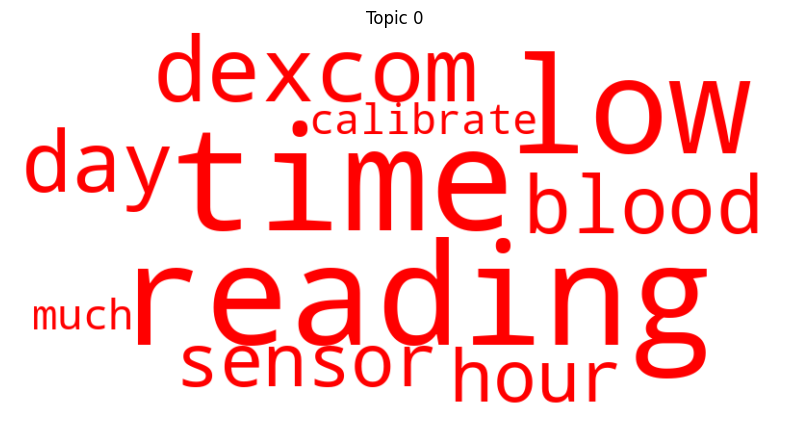

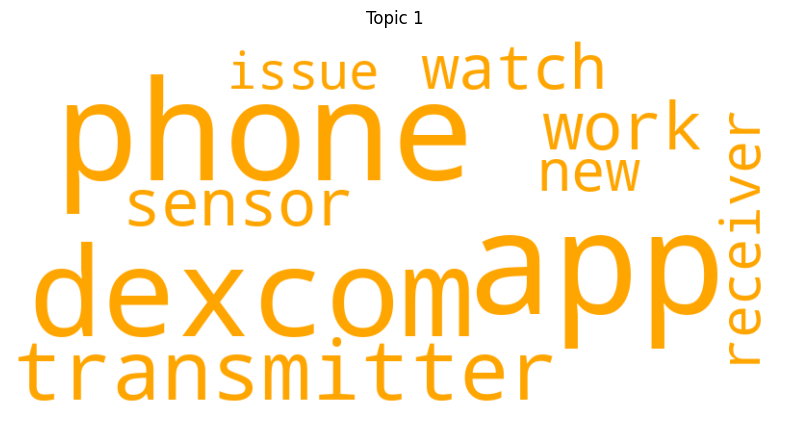

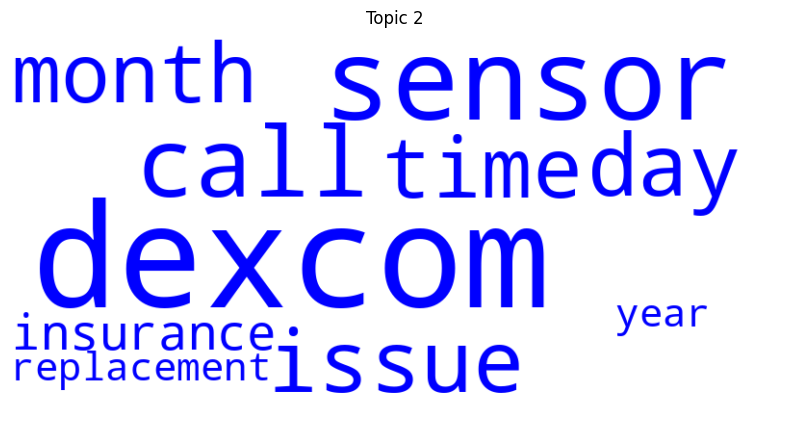

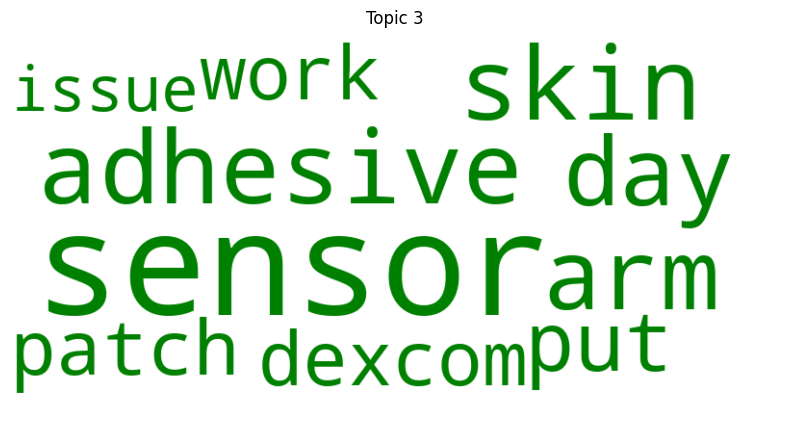

In [ ]:
from wordcloud import WordCloud

colors = ["red", "orange","blue","green"]

# Loop through 4 topics (from LDA)

for i in range(4):
    # Top 10 words
    topic_words =  lda_model.show_topic(i, 10)  
    topic_words_dict  = {word:score for word, score in topic_words}
    
    # WordlCloud for each topic  
    wc = W ordCloud(background_color="white", color_func=lambda *args, **kwargs: colors[i % len(colors)],  max_font_size=150, width=800,  height=400)     
    wc.generate_from_frequencies(topic_words_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear") 
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()   

Topics make sense from a narrative point of view, similar to LDA. 

In [ ]:
from bertopic import BERTopic



In [ ]:
texts = [' '.join(doc.split()) for doc in df['final']]

model = BERTopic(language="english")

# Fit the model to your data
topics, probabilities = model.fit_transform(texts)

# Get an overview of the topics
topics_overview = model.get_topic_info()
print(topics_overview.head(10))

   Topic  Count                                Name
0     -1   6285            -1_sensor_day_phone_time
1      0    612         0_arm_stomach_thigh_abdomen
2      1    514          1_dexcom_call_send_support
3      2    288        2_alert_alarm_vibrate_urgent
4      3    273  3_sensor_failed_dexcom_replacement
5      4    247          4_pump_tandem_tslim_signal
6      5    236  5_transmitter_battery_warning_dead
7      6    222     6_watch_face_apple_complication
8      7    217         7_rash_skin_flonase_itching
9      8    189            8_sensor_error_day_today


In [ ]:
n_words = 10

n_topics = topics_overview['Topic'].unique()

for topic in n_topics:
    # see top n words, ignore outlier topic
    if topic != -1: 
        words = model.get_topic(topic)
        print(f"\nTopic {topic}:")
        for word, prob in words:
            print(f"{word} ({prob:.2f})")



Topic 0:
arm (0.05)
stomach (0.03)
thigh (0.03)
abdomen (0.02)
upper (0.02)
spot (0.02)
fat (0.02)
belly (0.02)
area (0.01)
side (0.01)

Topic 1:
dexcom (0.02)
call (0.02)
send (0.01)
support (0.01)
free (0.01)
replacement (0.01)
contact (0.01)
year (0.01)
customer (0.01)
replace (0.01)

Topic 2:
alert (0.05)
alarm (0.05)
vibrate (0.03)
urgent (0.03)
sound (0.03)
low (0.02)
volume (0.02)
silent (0.02)
setting (0.02)
notification (0.02)

Topic 3:
sensor (0.02)
failed (0.01)
dexcom (0.01)
replacement (0.01)
call (0.01)
replace (0.01)
new (0.01)
support (0.01)
send (0.01)
replaced (0.01)

Topic 4:
pump (0.06)
tandem (0.05)
tslim (0.01)
signal (0.01)
phone (0.01)
receiver (0.01)
dexcom (0.01)
side (0.01)
slim (0.01)
support (0.01)

Topic 5:
transmitter (0.05)
battery (0.04)
warning (0.01)
dead (0.01)
serial (0.01)
reset (0.01)
rechargeable (0.01)
new (0.01)
month (0.01)
activated (0.01)

Topic 6:
watch (0.09)
face (0.06)
apple (0.04)
complication (0.03)
fossil (0.02)
series (0.02)
wearos 

In [ ]:
# reduce n otpics down to 8
model = BERTopic(language="english")

# fit
topics, probabilities = model.fit_transform(texts)

# Reduce the number of topics
model.reduce_topics(texts, topics, probabilities, nr_topics=8)

# Check the topics
topics_overview = model.get_topic_info()
print(topics_overview.head(10))

In [ ]:
model.visualize_topics()


Cool results! Never used BERT for topic modeling before. BERT utilizes HDBSCAN of terms to create clusters of topics. List of all topics outputting too many topics to interpret. Clusters of topic makes sense.<br><br>

Interesting that the outlier topic includes -1_sensor_day_phone_time, which makes intuitive sense based on narrative and show up as key topics for LDA and NMF.<br>

Ignoring the outlier topic, the topics are below <br>
0 Monitoring location preferences: body parts, sensors<br>
1 Customer support communications<br>
2 Alerts and emergencies<br>
3 Sensor reliability and replacements<br>
4 Co-use with closed loop insulin pump<br>
5 Battery life  <br>
6 Tracking and devices eg watches <br>
7 Skin reactions <br>
8 Sensor accuracy <br>